In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = (x_train > 0.5).astype("float32")
y_test = (x_test > 0.5).astype("float32")

In [3]:
inputs = Input(shape=(28,28,1))

# Encoder: CNN
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2,2))(x)  # (14,14,32)

# Treat height as time steps, width*channels as features
x = layers.Reshape((14, 14*32))(x)  # (batch, 14, 448)

# GRU layer
x = layers.GRU(128, return_sequences=True)(x)  # (batch, 14, 128)

# Reshape back to 2D grid
x = layers.Reshape((14, 16, 8))(x)  # 14*16 ≈ 128 features

# Upsample to match input size
x = layers.UpSampling2D(size=(2,2))(x)  # (28,32,8)
x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(x)  # (28,32,16)
x = layers.Conv2D(1, (3,3), padding="same", activation="sigmoid")(x)  # (28,32,1)

# Crop width to match exactly 28
outputs = layers.Cropping2D(cropping=((0,0),(2,2)))(x)  # (28,28,1)

# Compile
model = models.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 14, 448)           0         
                                                                 
 gru (GRU)                   (None, 14, 128)           221952    
                                                                 
 reshape_1 (Reshape)         (None, 14, 16, 8)         0         
                                                             

In [4]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=64
)

Epoch 1/5
938/938 [==============================] - 75s 28ms/step - loss: 0.0554 - accuracy: 0.9793 - val_loss: 0.0222 - val_accuracy: 0.9908
Epoch 2/5
938/938 [==============================] - 24s 26ms/step - loss: 0.0196 - accuracy: 0.9919 - val_loss: 0.0175 - val_accuracy: 0.9927
Epoch 3/5
938/938 [==============================] - 22s 24ms/step - loss: 0.0168 - accuracy: 0.9930 - val_loss: 0.0158 - val_accuracy: 0.9934
Epoch 4/5
938/938 [==============================] - 22s 24ms/step - loss: 0.0152 - accuracy: 0.9936 - val_loss: 0.0151 - val_accuracy: 0.9937
Epoch 5/5
938/938 [==============================] - 22s 24ms/step - loss: 0.0142 - accuracy: 0.9940 - val_loss: 0.0138 - val_accuracy: 0.9942


1/1 [==============================] - 1s 870ms/step


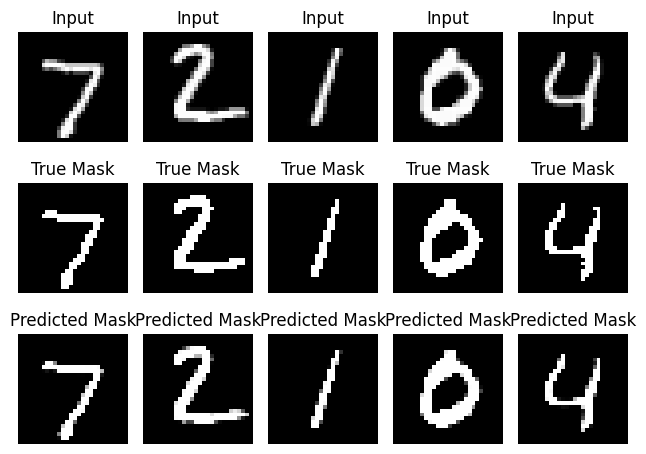

In [5]:
# Predict masks on test set
preds = model.predict(x_test[:5])

# Plot original image, true mask, and predicted mask
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.title("Input")
    plt.axis("off")

    plt.subplot(3,5,5+i+1)
    plt.imshow(y_test[i].squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(3,5,10+i+1)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
